In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

# Summarize results into Pandas DataFrame

In [2]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)

    return model_meta

In [3]:
model_meta = pd.DataFrame()

root_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'film',
                        'fixed_batch_size',
                        'fixed_valid_set',
                        'film_layer_all_bn1-3')
base_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'film',
                        'fixed_batch_size',
                        'variable_valid_set',
                        'film_layer_all_bn1-3')
source_train_baseline_dir = os.path.join(base_dir, 'film_s_20k_t_20')
exp_dir = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]


for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet') and f.startswith('source'):
        trial_results = summarize(os.path.join(root_dir, source_train_baseline_dir), f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(root_dir, source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if (f.endswith('.parquet')) and ('target' in f):
            trial_results = summarize(os.path.join(root_dir, d), f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

# Summarize performance for trained models

In [4]:
source_meta = model_meta[model_meta['phase'] == 'source']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [5]:
source_meta.mean()[performance_cols]

mimic_test_loss       0.611880
mimic_test_acc        0.757500
mimic_test_auc        0.846473
chexpert_test_loss    0.576572
chexpert_test_acc     0.847750
chexpert_test_auc     0.913056
dtype: float64

In [6]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_best_test_loss', 'mimic_final_test_loss', 'mimic_best_test_acc', 'mimic_final_test_acc',
                    'chexpert_best_test_loss', 'chexpert_final_test_loss', 'chexpert_best_test_acc', 'chexpert_final_test_acc']

In [7]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.618631               0.620615   
50                            0.620596               0.621602   
100                           0.617534               0.617252   
200                           0.615101               0.614810   
500                           0.614786               0.613400   
1000                          0.610923               0.611318   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.774254              0.773251   
50                           0.777388              0.778015   
100                          0.779393              0.781274   
200                          0.771747              0.769115   
500                          0.777012              0.777388   
1000                         0.782276              0.782276   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.588885                  0.589755   
50                               0.588002                  0.587883   
100                              0.585729                  0.585986   
200                              0.582254                  0.582480   
500                              0.582566                  0.582412   
1000                             0.585472                  0.584182   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.841625                 0.816750  
50                              0.827250                 0.824125  
100                             0.828000                 0.828625  
200                             0.831500                 0.830750  
500                             0.844625                 0.845625  
1000                            0.850000                 0.849125

In [8]:
target_meta.groupby('n_target_samples').mean()[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.614686               0.617643   
50                            0.617722               0.617935   
100                           0.615048               0.614019   
200                           0.611998               0.612045   
500                           0.610865               0.610303   
1000                          0.608559               0.608506   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.769575              0.768697   
50                           0.773377              0.773293   
100                          0.772165              0.773251   
200                          0.764644              0.764310   
500                          0.772290              0.772123   
1000                         0.776427              0.780354   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.584731                  0.587679   
50                               0.585288                  0.585448   
100                              0.583416                  0.582931   
200                              0.580129                  0.580311   
500                              0.580508                  0.580553   
1000                             0.581530                  0.581238   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.816875                 0.808333  
50                              0.819250                 0.819167  
100                             0.821167                 0.821708  
200                             0.824083                 0.822958  
500                             0.830958                 0.830042  
1000                            0.826667                 0.833292

In [9]:
target_meta.groupby('n_target_samples').std()[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.004003               0.002902   
50                            0.004972               0.005302   
100                           0.002430               0.002859   
200                           0.003911               0.003613   
500                           0.004966               0.004396   
1000                          0.002066               0.002520   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.004701              0.004999   
50                           0.004358              0.004829   
100                          0.006815              0.008150   
200                          0.008693              0.008106   
500                          0.004425              0.004668   
1000                         0.006092              0.002419   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.004594                  0.002086   
50                               0.002439                  0.002263   
100                              0.003174                  0.003138   
200                              0.001883                  0.001882   
500                              0.002988                  0.003087   
1000                             0.004295                  0.003615   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.021434                 0.007299  
50                              0.008128                 0.004819  
100                             0.008698                 0.010707  
200                             0.009409                 0.009155  
500                             0.011947                 0.013703  
1000                            0.021427                 0.014356

In [10]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_final_test_loss', 'mimic_final_test_acc', 'mimic_final_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_final_test_loss', 'chexpert_final_test_acc', 'chexpert_final_test_auc'])

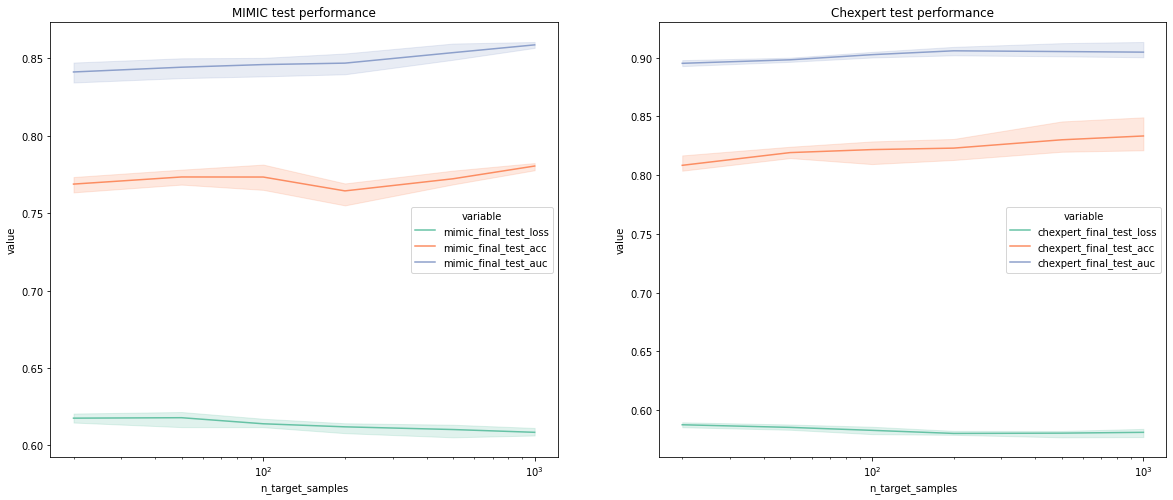

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
ax[0].set(xscale='log')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')
ax[1].set(xscale='log');

# Visualize training and validation losses for the two training phases

In [12]:
def plot_losses(df, phase='target', n_target_samples=20, loss_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{loss_type}_loss'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    losses = np.stack(stackable)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


## 20 MIMIC samples

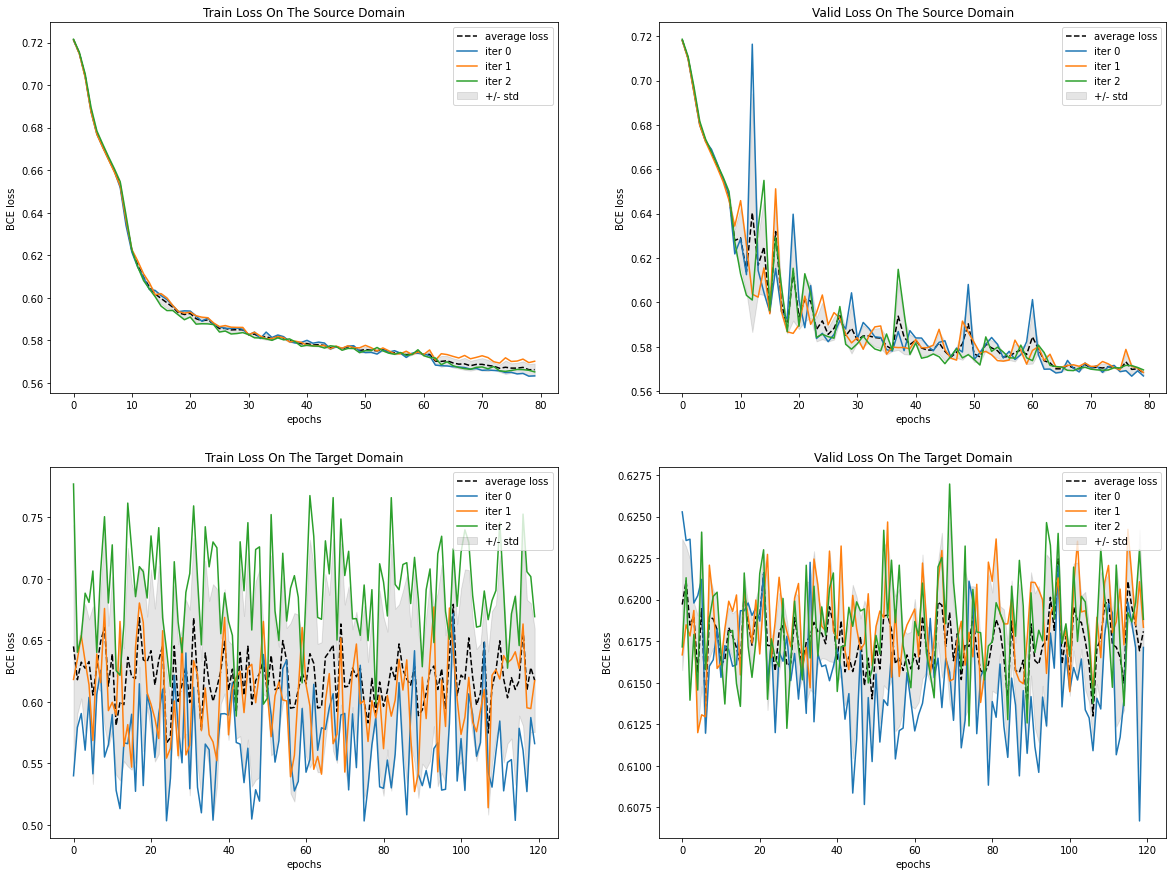

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

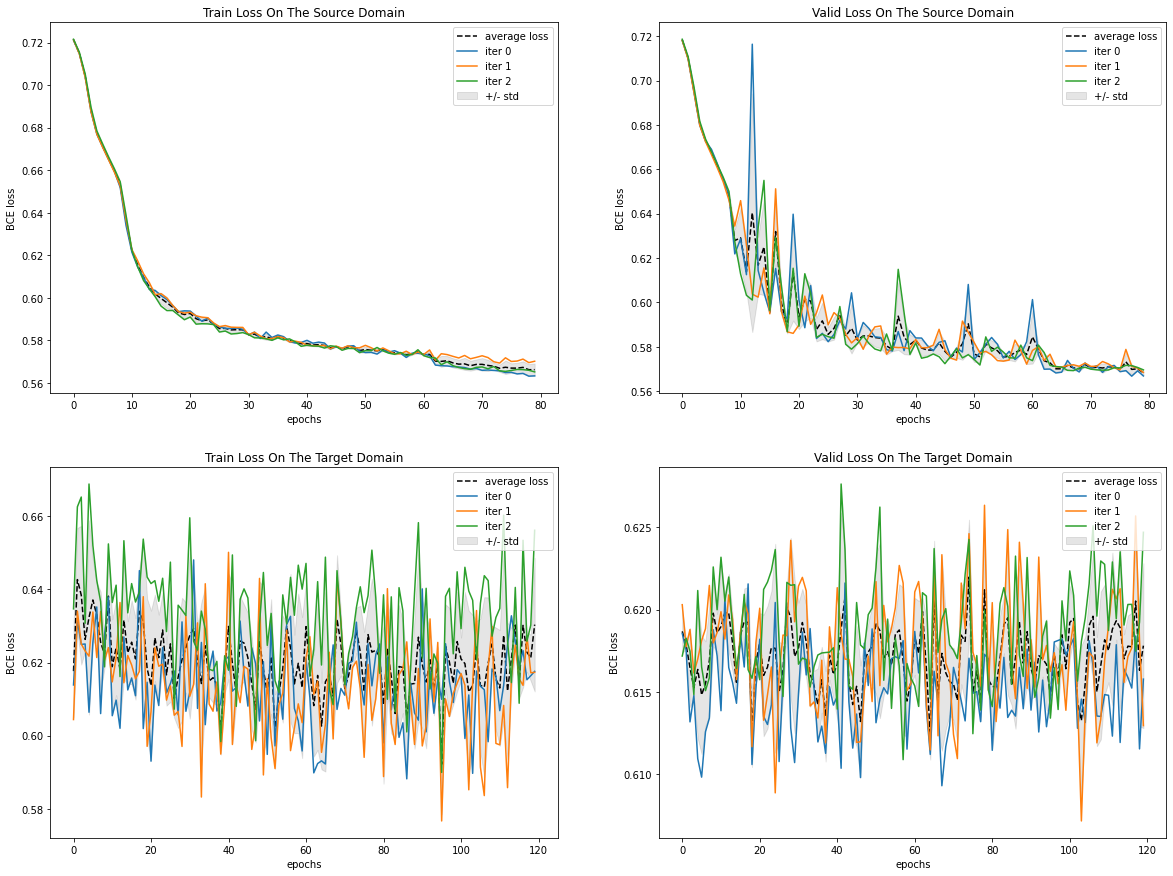

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

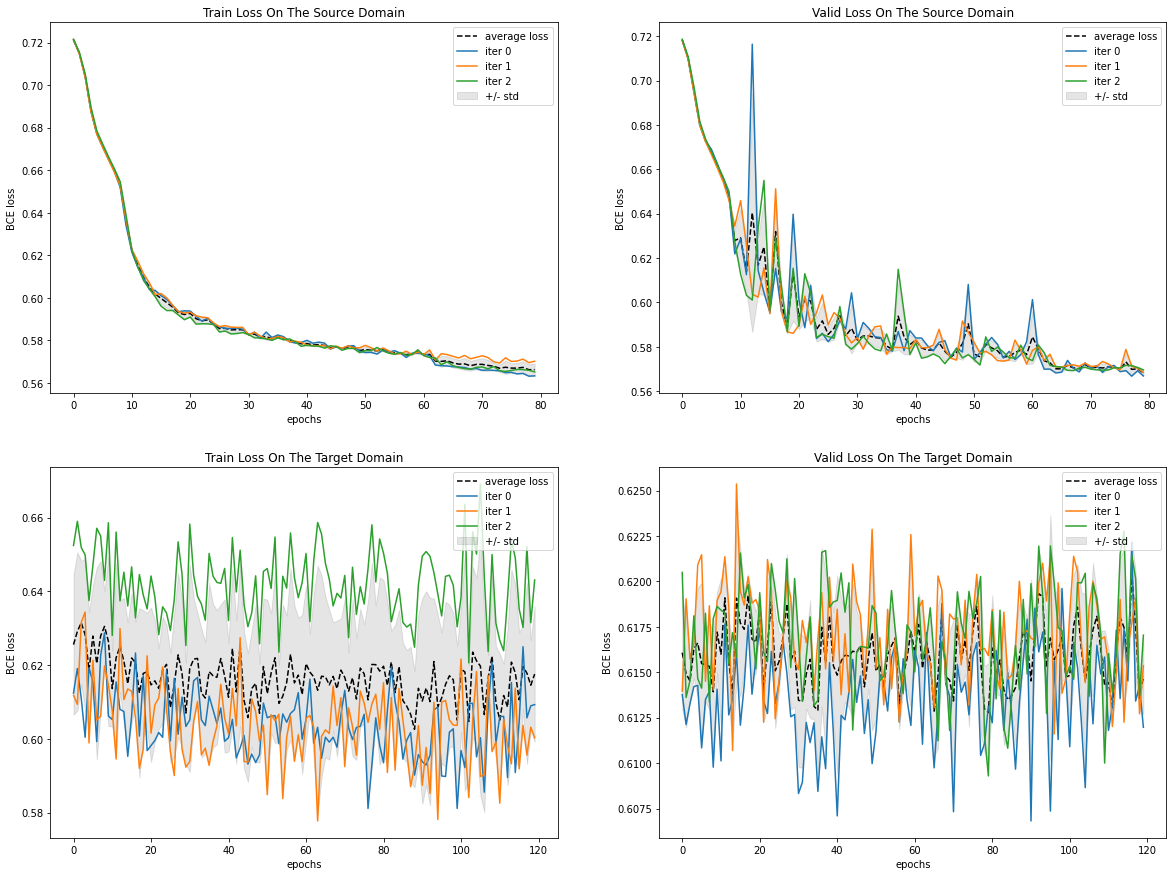

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

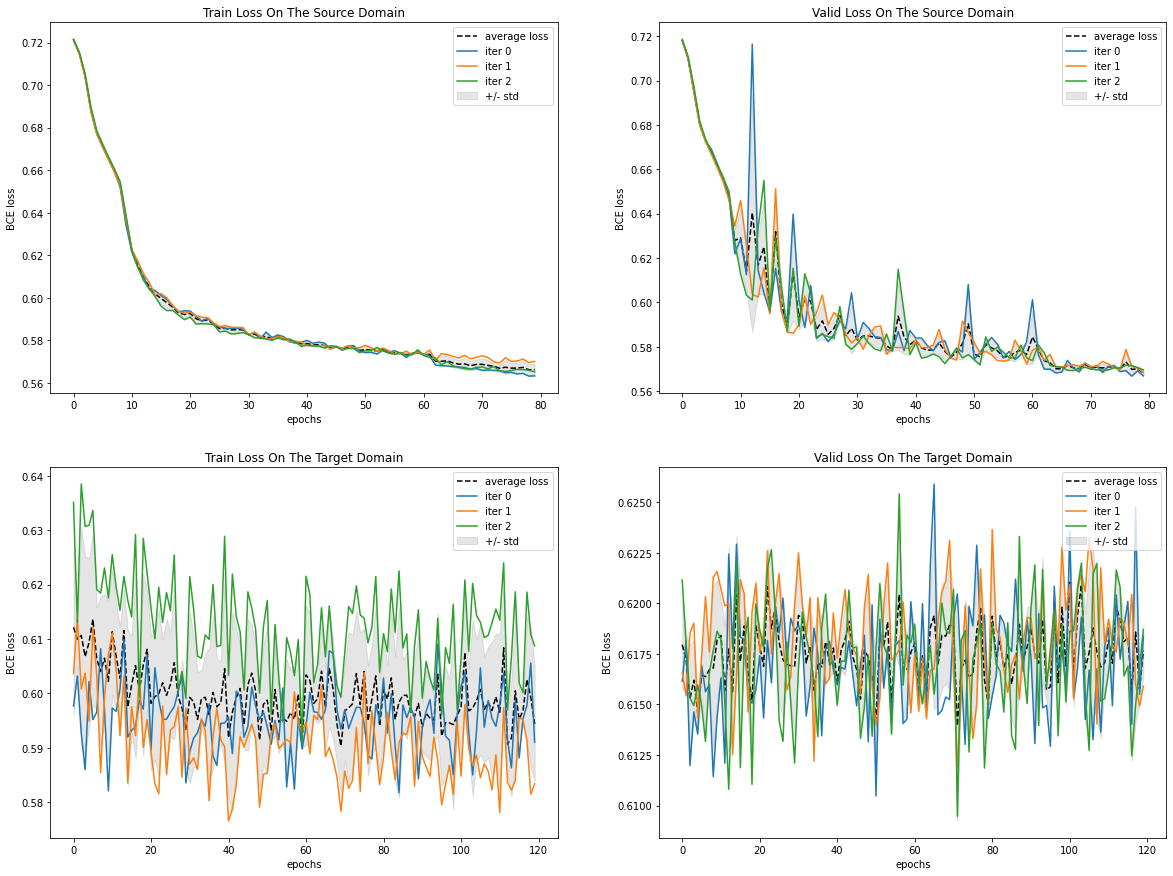

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

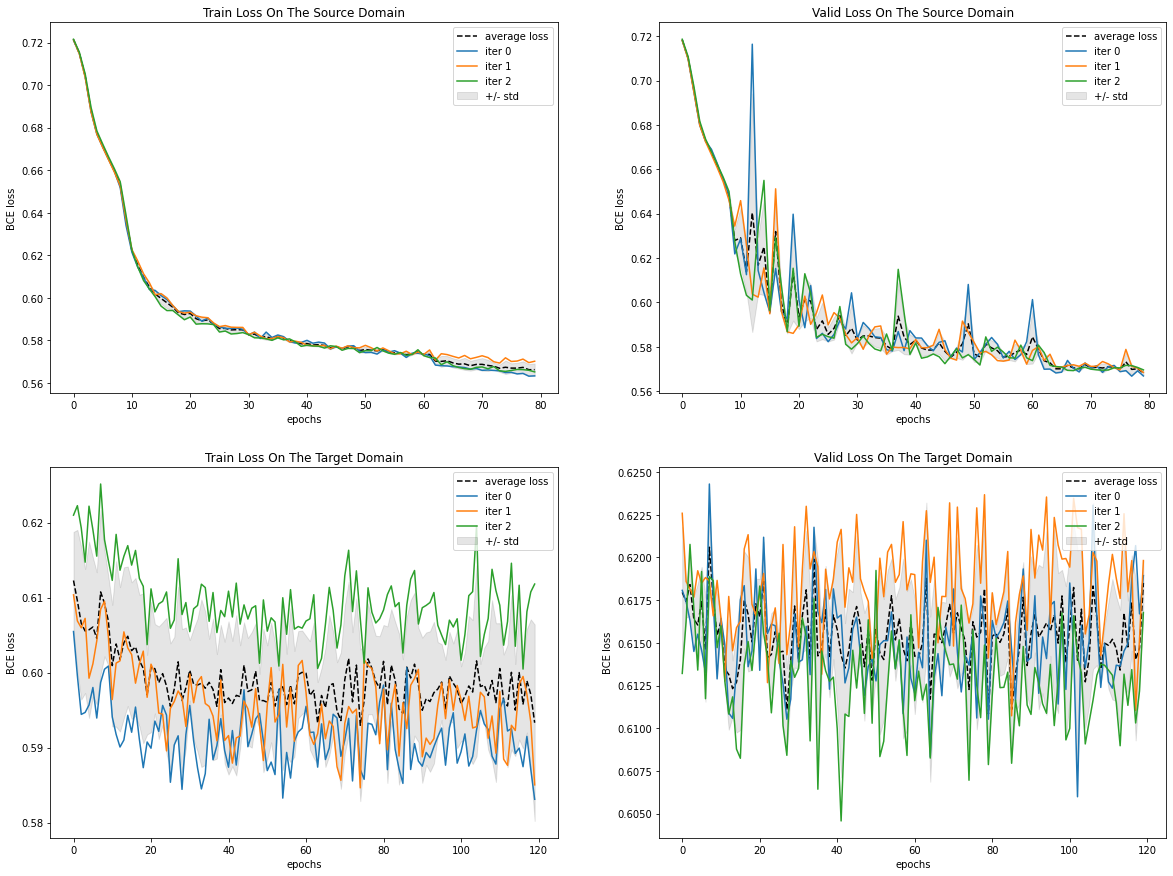

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

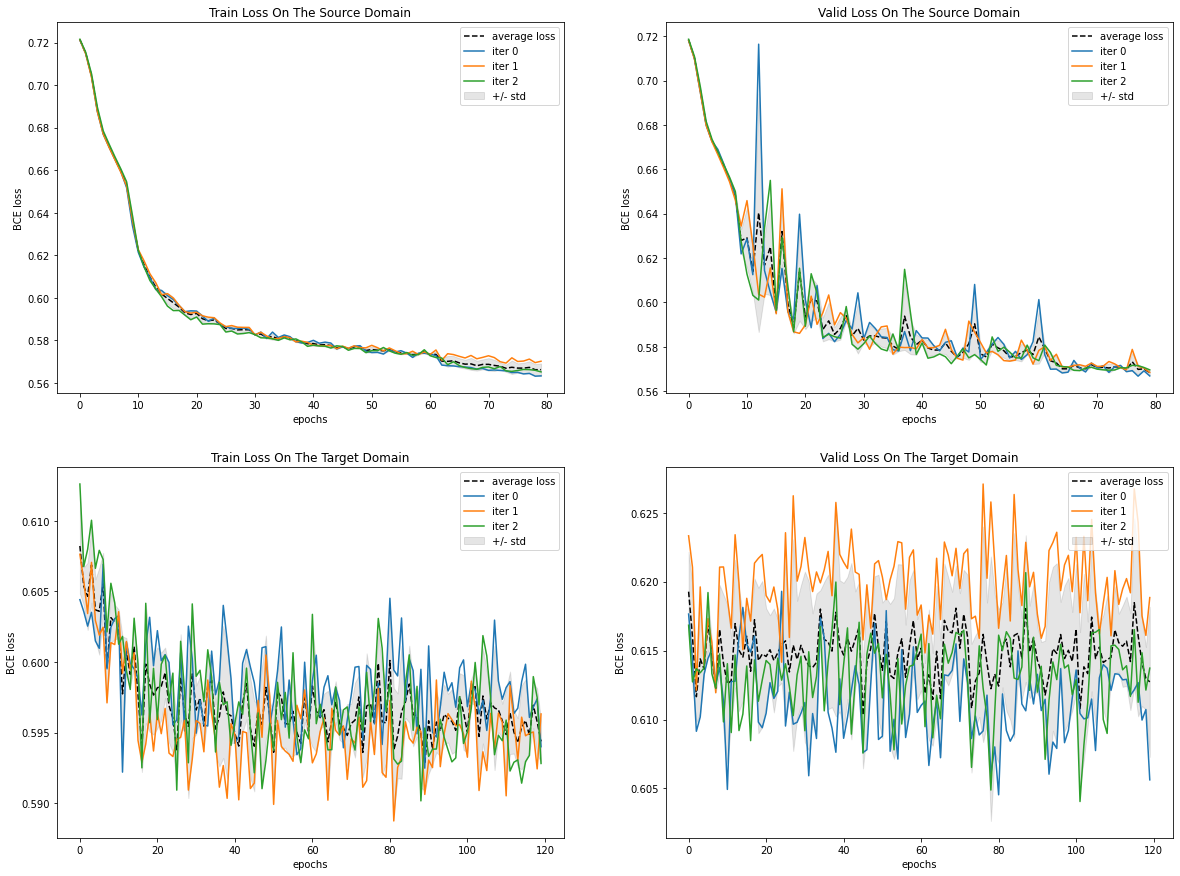

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

# Visualize training and validation accuracies for the two training phases

In [19]:
def plot_accuracies(df, phase='target', n_target_samples=20, acc_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{acc_type}_acc'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    acc = np.stack(stackable)

    avg_acc = np.mean(acc, axis=0)
    upper_ = avg_acc + np.std(acc, axis=0)
    lower_ = avg_acc - np.std(acc, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_acc, 'k--')
    ax.plot(acc.T)
    ax.legend(['average accuracy', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


## 20 MIMIC samples

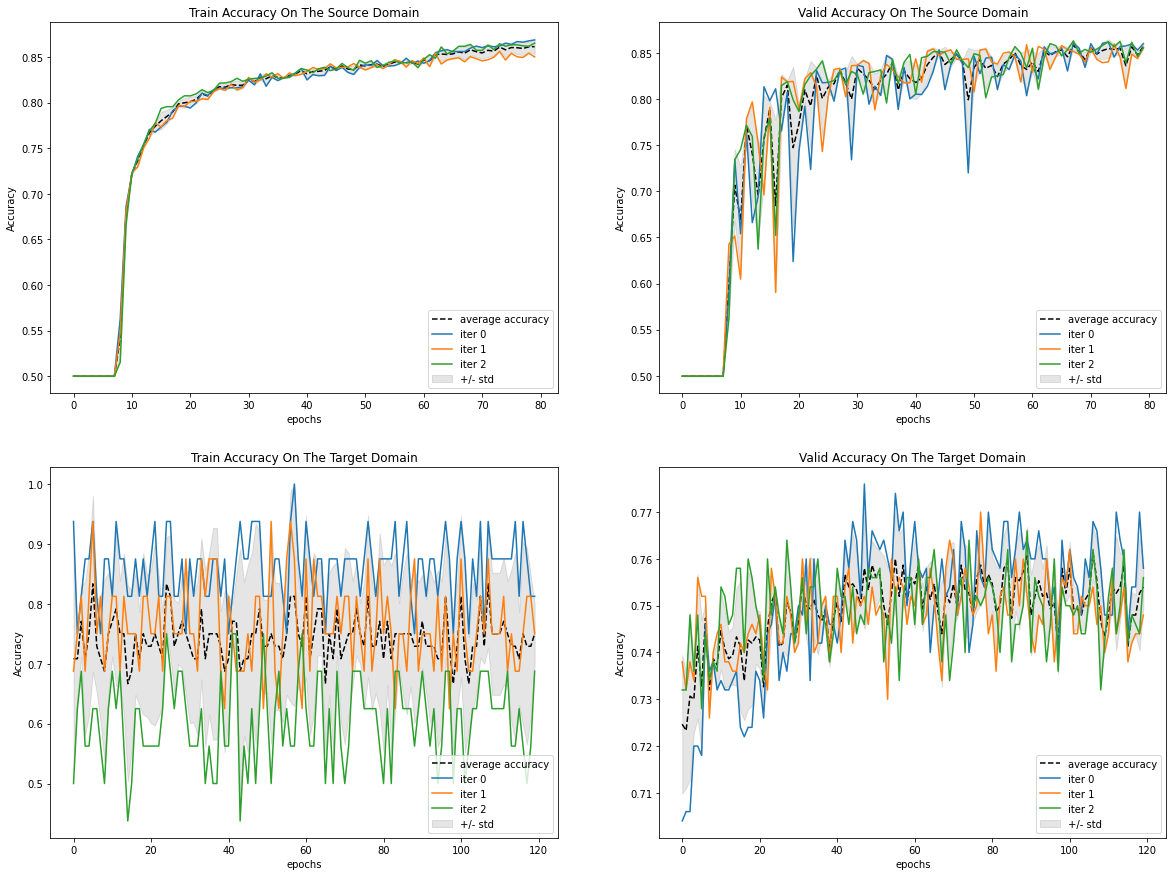

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

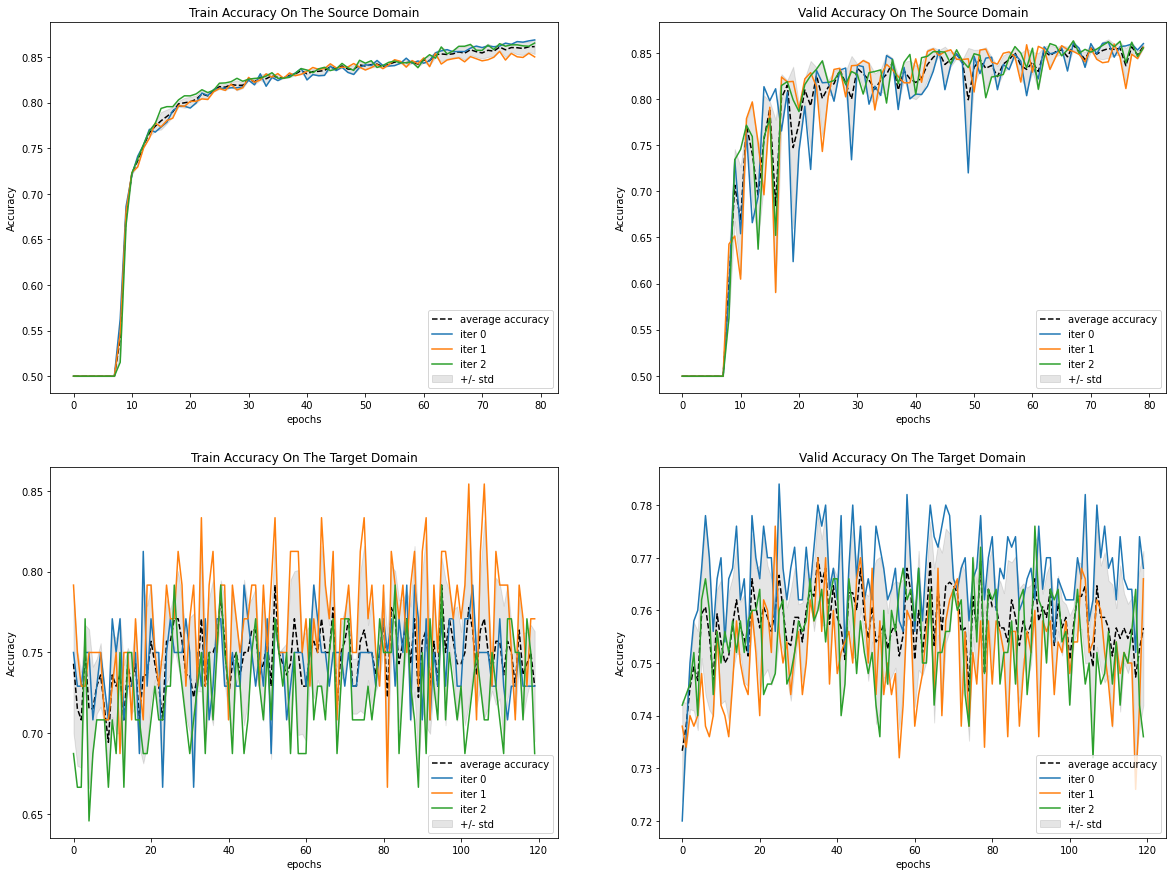

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

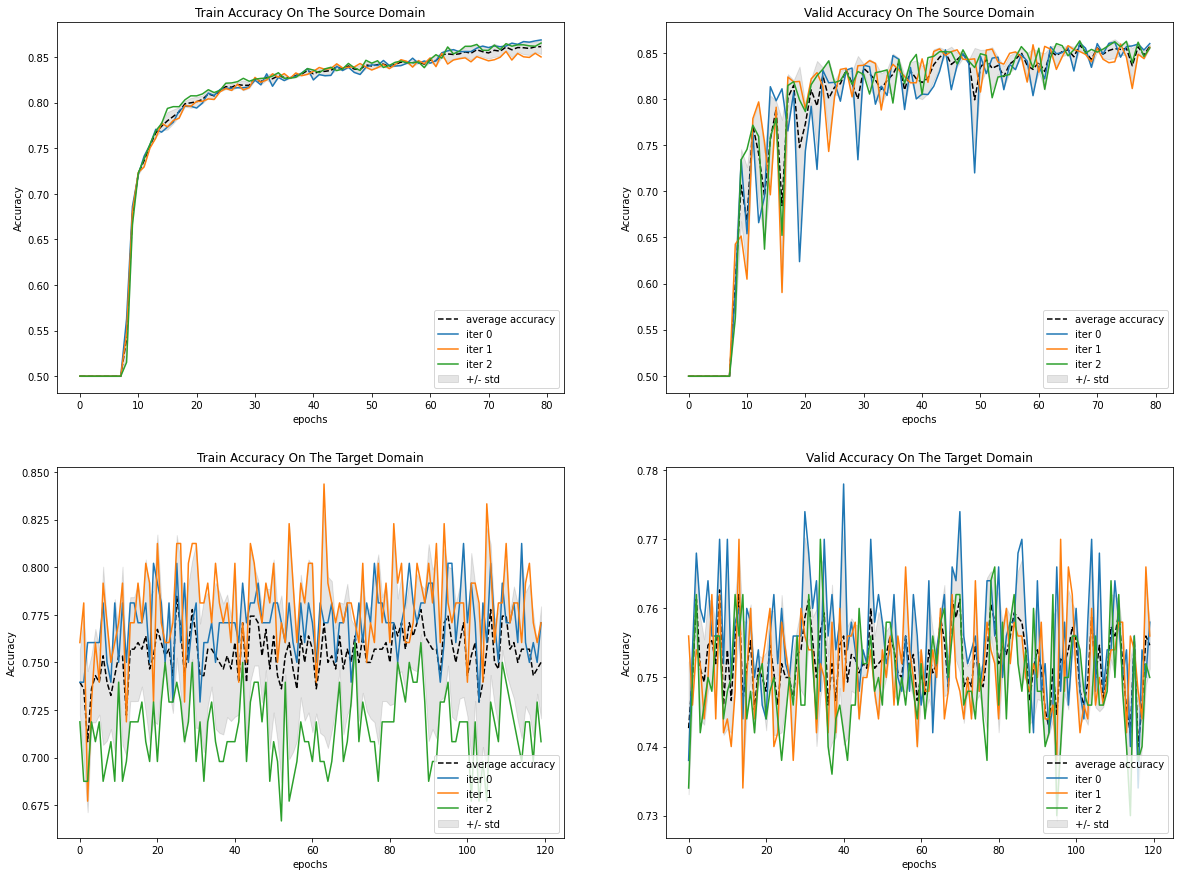

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

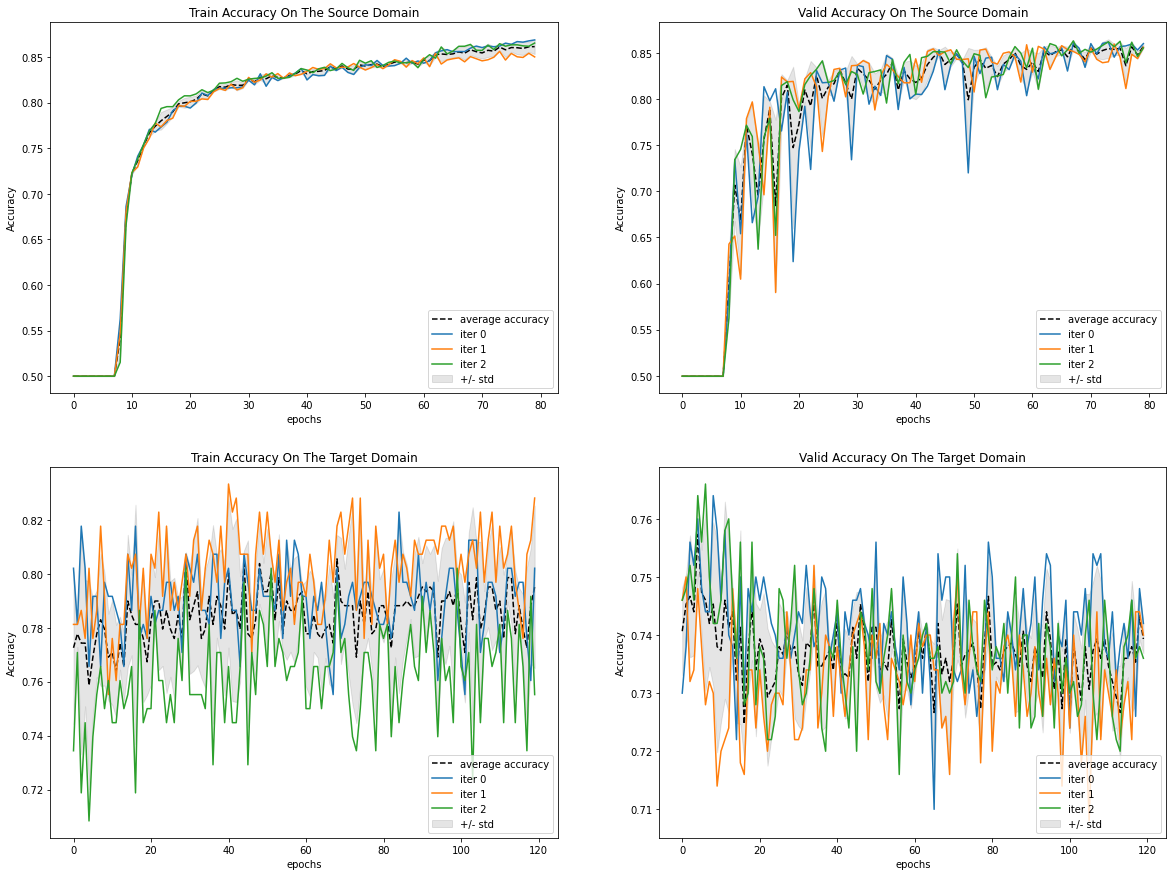

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

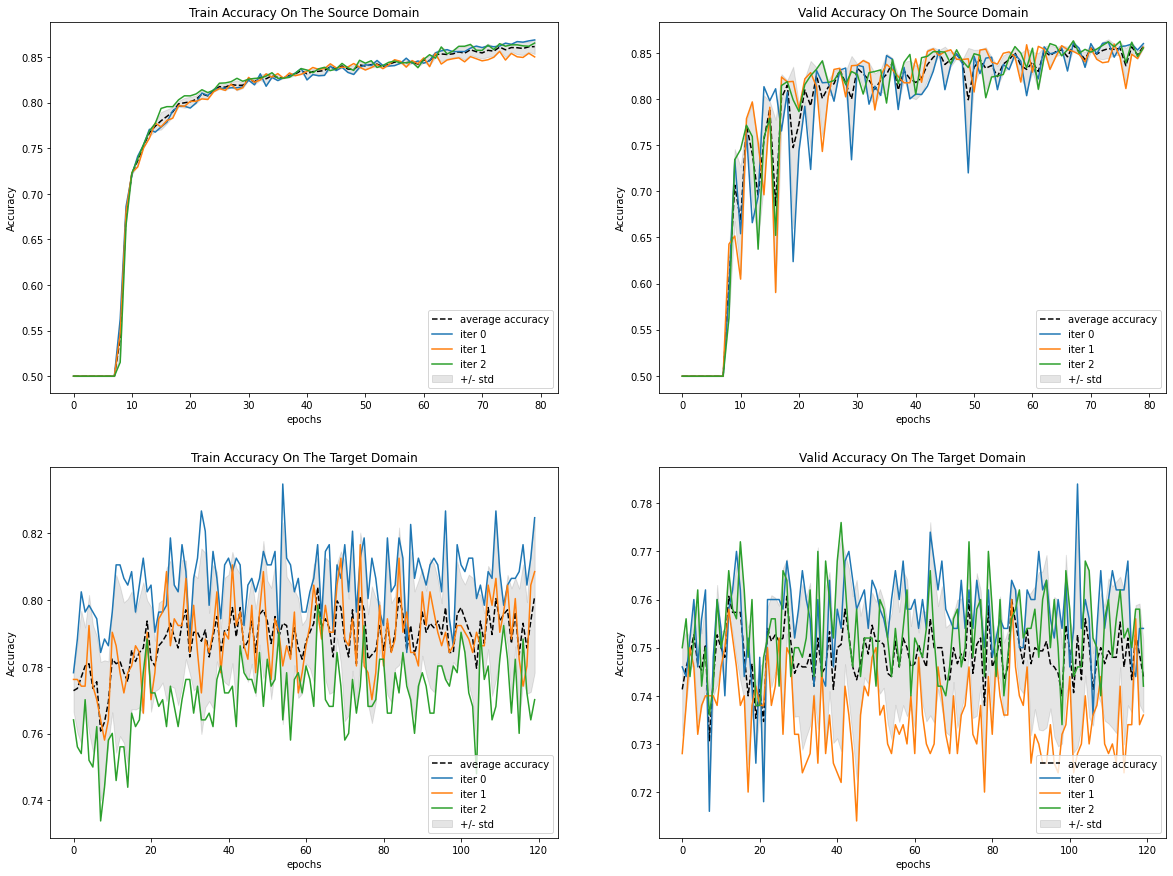

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

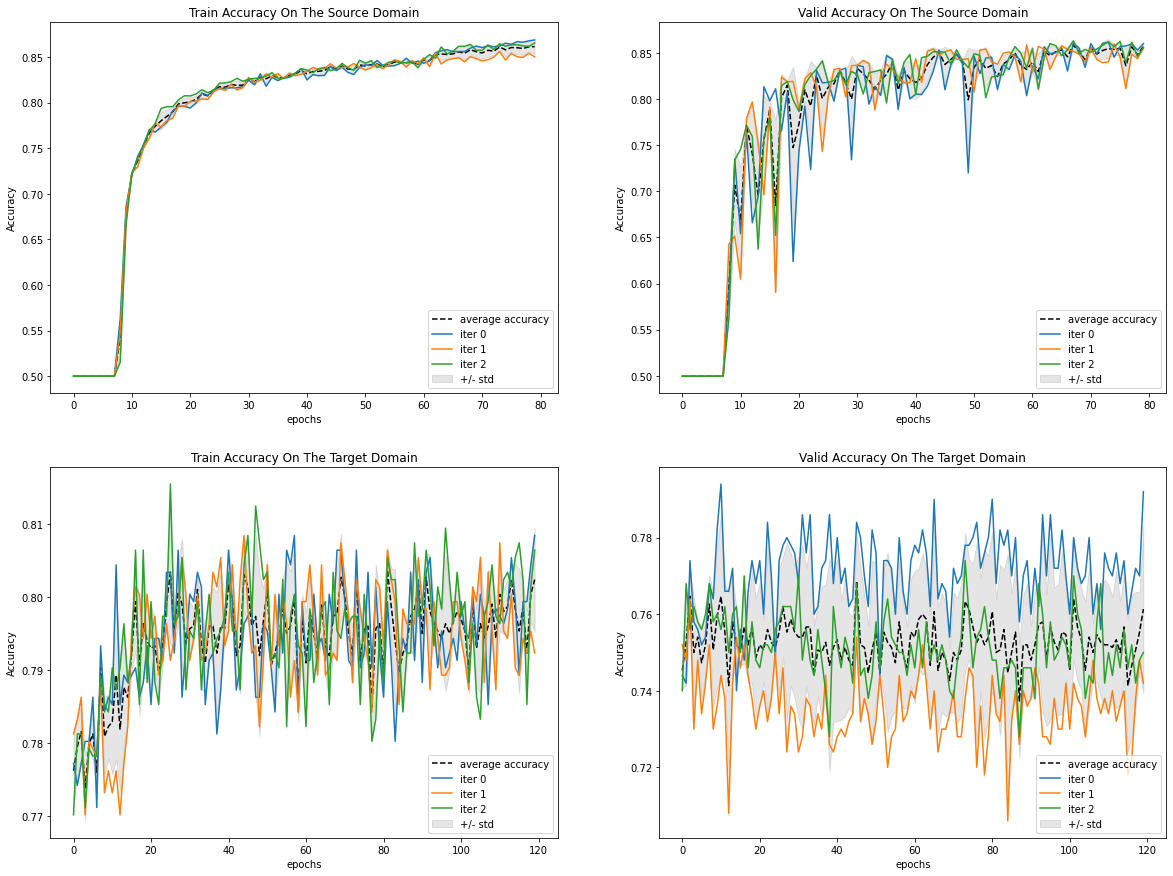

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

# Summarize training metrics for trained models

In [26]:
target_meta = model_meta[model_meta['phase'] == 'target']

training_cols = ['final_train_loss', 'final_valid_loss', 'final_valid_acc', 'mimic_final_test_acc', 'chexpert_final_test_acc']

In [27]:
target_meta.groupby('n_target_samples').mean(numeric_only=True)[training_cols]

final_train_loss  final_valid_loss  final_valid_acc  \
n_target_samples                                                        
20                        0.617480          0.618094         0.754000   
50                        0.630357          0.617812         0.756667   
100                       0.617555          0.614791         0.754667   
200                       0.594367          0.617658         0.739333   
500                       0.593319          0.618509         0.744000   
1000                      0.594383          0.612732         0.761333   

                  mimic_final_test_acc  chexpert_final_test_acc  
n_target_samples                                                 
20                            0.768697                 0.808333  
50                            0.773293                 0.819167  
100                           0.773251                 0.821708  
200                           0.764310                 0.822958  
500                           0.772123                 0.830042  
1000                          0.780354                 0.833292